<a href="https://colab.research.google.com/github/stefaniemeliss/IADS_SC_2022_CausalInference/blob/main/Exercise_IHDP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Causal Inference - Exercise (IHDP)

This is an opportunity for everyone to put into practice everything we have learnt so far. The data for this exercise comes from Infant Health Development Program study and was modified specifically for causal inference estimation purposes. More precisely, this dataset was formally introduced by [Hill (2011)](https://doi.org/10.1198/jcgs.2010.08162). It is a commonly used semi-simulated dataset in the CI community that combines pre-treatment covariates (X) and treatment assignments (T) from a real study, and simulated outcomes (Y). Because all outcomes are generated (both $y_1$ and $y_0$), we can measure individual as well as average treatment effect errors. For training purposes, only one of the outcomes is available to the estimator. The other is hidden and used only for evaluation purposes.

The experiment where the covariates come from measured various aspects of premature infants and their mothers, and how receiving specialised childcare affected the cognitive test score of the infants later on. The treatment groups are made imbalanced by removing a subset of the treated individuals. The variables are a mixture of contonuous and binary features. Treatment is binary. The outcome Y is continuous. Overall, we have 25 background features X. The data consists of 747 samples (139 treated, 608 control).

In terms of evaluation metrics, we are interested in predicting both individual and average treatment effects for this task. As the outcomes are simulated, we have access to both true outcomes $\mathcal{Y}_1$ and $\mathcal{Y}_0$ for each individual (i). As a result, we have access to true ITEs and true ATE:

$$ITE^{(i)} = \mathcal{Y}_1^{(i)} - \mathcal{Y}_0^{(i)}$$

$$ATE = \mathbb{E}[ITE]$$

We can define our predictions as:

$$\widehat{ITE}^{(i)} = \hat{y}_1^{(i)} - \hat{y}_0^{(i)}$$

$$\widehat{ATE} = \frac{1}{n}\sum \limits_{i=1}^{n}\widehat{ITE}^{(i)}$$

This allows us to define measurement errors with respect to each as:

$$\epsilon_{PEHE} = \sqrt{\frac{1}{n}\sum \limits_{i=1}^{n}(\widehat{ITE}^{(i)} - ITE^{(i)})^2}$$

$$\epsilon_{ATE} = \left| \widehat{ATE} - ATE \right|$$

Where PEHE stands for Precision in Estimation of Heterogeneous Effect, and which essentially is a Root Mean Squared Error (RMSE) between predicted and true ITEs. Implementations of both metrics are provided below.

In [ ]:
def rmse(a, b):
    return np.sqrt(((a - b)**2).mean())

def ate_error(pred_te, true_te):
  return np.abs(np.mean(pred_te) - np.mean(true_te))

def pehe_error(pred_te, true_te):
  return rmse(true_te, pred_te)

We suggest the following steps:
1. Import packages.
    1. Remember to install EconML if you want to use it.
2. Data.
    1. Can be accessed at the following URLs:
        1. Training: https://github.com/dmachlanski/iads-summer-school-causality-2022/raw/main/labs/data/ihdp_train.npz
        2. Testing: https://github.com/dmachlanski/iads-summer-school-causality-2022/raw/main/labs/data/ihdp_test.npz
    2. Use 'wget' command to download them into the notebook (or upload manually).
    3. Explore the data (print a few samples, plot distributions - see plot_dist function below).
3. Data pre-processing.
    1. No data splitting required (train and test already provided).
    2. Scaling.
4. Train estimators of your choice (re-use already presented ones or explore different methods.
  1. EconML - [CATE estimators](https://econml.azurewebsites.net/reference.html#cate-estimators).
  2. scikit-learn - [supervised methods](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning).
5. Make predictions.
6. Evaluate your models.
    1. Measure ATE and PEHE errors.

In [ ]:
def _trim_axs(axs, N):
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

def plot_dist(data, bins=10):
    """
    data: 2-dimensional numpy array
    bins: number of bins in the histograms
    """

    if data.shape[1] > 1:
        sq = math.sqrt(data.shape[1])
        d_ceil = math.ceil(sq)
        d_floor = math.floor(sq)

        if (d_ceil * d_floor) >= data.shape[1]:
            n_rows = d_floor
            n_cols = d_ceil
        else:
            n_rows = n_cols = d_ceil

        _, axs = plt.subplots(n_rows, n_cols, figsize=(24, 8))
        axs = _trim_axs(axs, data.shape[1])

        for i, ax in enumerate(axs):
            ax.hist(data[:, i], bins=bins)
            ax.set_title(str(i+1))
    else:

        plt.hist(data, bins=bins)
    
    plt.show()

### 1. Import packages

In [ ]:
!pip install econml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from econml.metalearners import XLearner
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import math

### 2. Data

In [ ]:
!wget https://github.com/dmachlanski/iads-summer-school-causality-2022/raw/main/labs/data/ihdp_train.npz # training data
!wget https://github.com/dmachlanski/iads-summer-school-causality-2022/raw/main/labs/data/ihdp_test.npz # test data

--2022-07-28 16:02:11--  https://github.com/dmachlanski/iads-summer-school-causality-2022/raw/main/labs/data/ihdp_train.npz
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dmachlanski/iads-summer-school-causality-2022/main/labs/data/ihdp_train.npz [following]
--2022-07-28 16:02:11--  https://raw.githubusercontent.com/dmachlanski/iads-summer-school-causality-2022/main/labs/data/ihdp_train.npz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 151488 (148K) [application/octet-stream]
Saving to: ‘ihdp_train.npz.4’

ihdp_train.npz.4    100%[===================>] 147.94K  --.-KB/s    in 0.05s   

2022-0

#### Training data

Training data consists of 672 rows.

In [ ]:
# training data
train = np.load('ihdp_train.npz')
train.files

['x', 't', 'y', 'te']

In [ ]:
for f in train.files:
  print(f'{f}: {train[f].shape}')

x: (672, 25)
t: (672, 1)
y: (672, 1)
te: (672, 1)


###### X train data

X is a vector with 25 dimensions.
Many of them are binary, one is multi-categorical.
[1, 2, 3, 5, 6] are continuous, but not normally distributed.

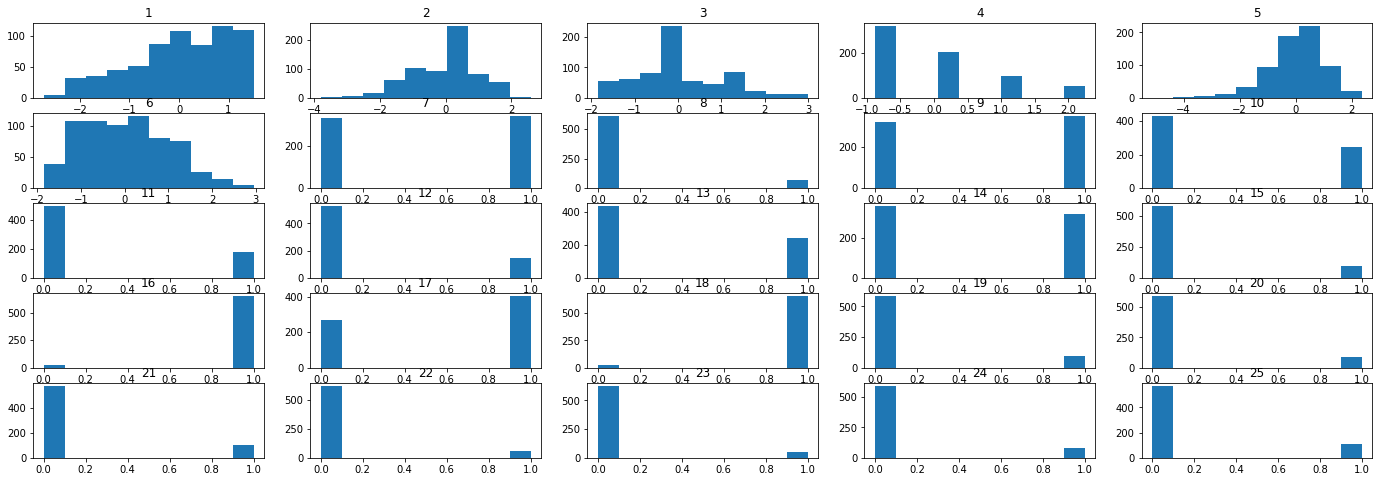

In [ ]:
plot_dist(train['x'])

##### T train data

T is a single-dimensional vector with binary values in uneven distributions.

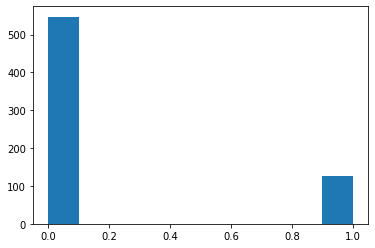

In [ ]:
plot_dist(train['t'])

##### the Y train data

Y is a single-dimensional vector with continuous data.

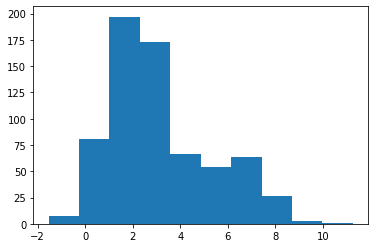

In [ ]:
plot_dist(train['y'])

##### TE train data

Y is a single-dimensional vector with continuous data (ceiling around 4).

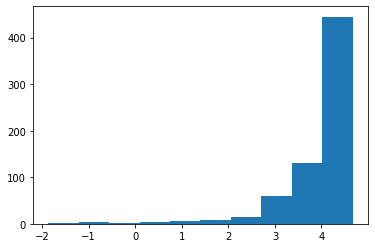

In [ ]:
plot_dist(train['te'])

We have  single-dimensional vectors, each of which consisting of 10,000 samples. We are going to reshape them to 2D vectors as some methods prefer this representation of data, though we will have to switch back and forth between 1D and 2D representation often as this requirement varies across methdos.

#### Test data
Training data consists of 75 rows.

In [ ]:
# test data
test = np.load('ihdp_test.npz')
test.files

['x', 't', 'y', 'te']

In [ ]:
for f in test.files:
  print(f'{f}: {test[f].shape}')

x: (75, 25)
t: (75, 1)
y: (75, 1)
te: (75, 1)


#### X test data

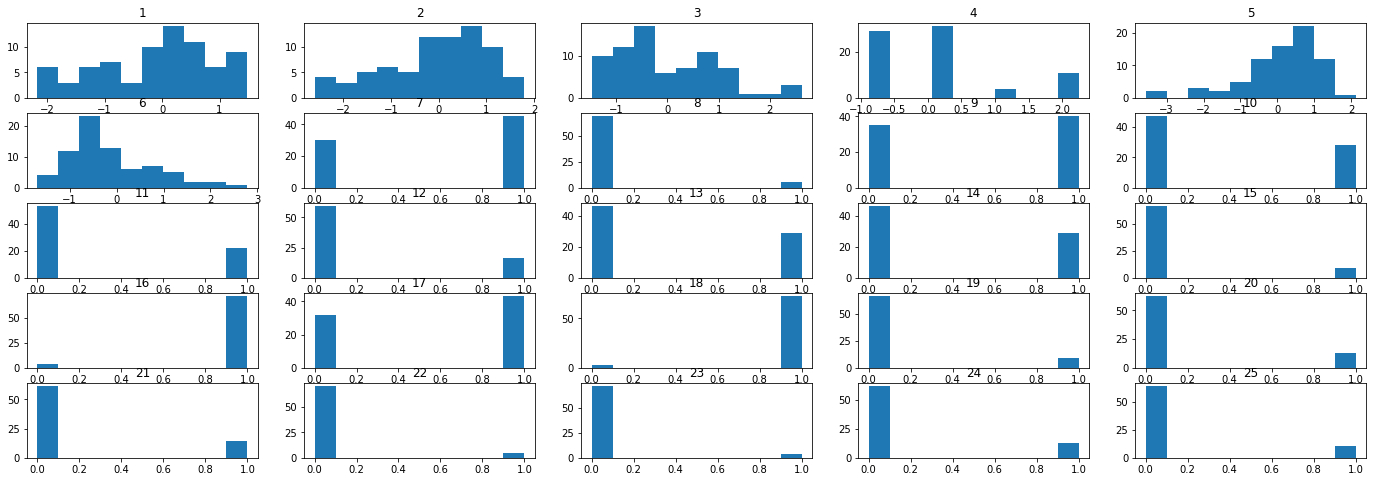

In [ ]:
plot_dist(test['x'])

#### T test data

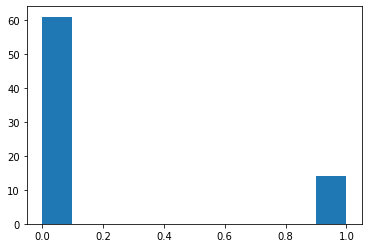

In [ ]:
plot_dist(test['t'])

#### Y test data

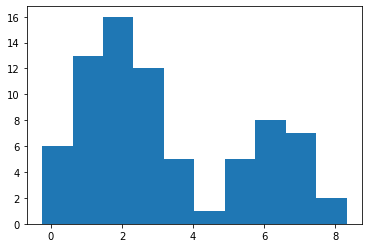

In [ ]:
plot_dist(test['y'])

#### TE test data

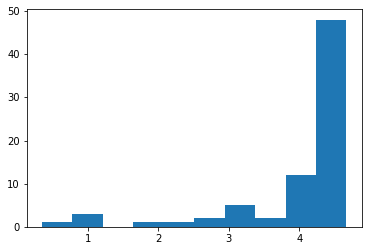

In [ ]:
plot_dist(test['te'])

### 3. Data pre-processing

In [ ]:
# move data into array that can be indexed
x_train = train['x'].reshape(-1, 25)
t_train = train['t'].reshape(-1, 1)
y_train = train['y'].reshape(-1, 1)
te_train = train['te'].reshape(-1, )

x_test = test['x'].reshape(-1, 25)
t_test = test['t'].reshape(-1, 1)
y_test = test['y'].reshape(-1, 1)
te_test = test['te'].reshape(-1, )

In [ ]:
# scale x data at column indices [0, 1, 2, 4, 5]

cols = [0, 1, 2, 4, 5]

for col in cols:
  scaler_x = StandardScaler()
  #x_scale = scaler_x.fit_transform(x_train[:,col].reshape(-1,1)) # compute scaling
  #x_train[:,col] = x_scale.flatten() # replace in dataset
  x_train[:,col] = scaler_x.fit_transform(x_train[:,col].reshape(-1,1)).flatten() # compute scaling
  x_test[:,col] = scaler_x.transform(x_test[:,col].reshape(-1,1)).flatten() # apply to test data


### 4. Train estimators of your choice (re-use already presented ones or explore different methods)

#### Random Forest

In [ ]:
rf = RandomForestRegressor()

# Train on the training data.
# In the supervised setting, our usual X here consists of X and T.
# The target is Y - the outcome.
# Input: [X, T], output: Y.
# np.concatenate([x_train, t_train], axis=1) --> transforms data into array with n rows and 2 columns
rf.fit(np.concatenate([x_train, t_train], axis=1), y_train.flatten())

# Predictions
# Note we set T to a specific value for ALL individuals.
# These are interventional distributions - P(Y|X, do(T=t)).

# Training predictions:
# Predict Y_0 given [X, 0]
rf_y0_in = rf.predict(np.concatenate([x_train, np.zeros_like(t_train)], axis=1))
# Predict Y_1 given [X, 1]
rf_y1_in = rf.predict(np.concatenate([x_train, np.ones_like(t_train)], axis=1))

# Test predictions (model's generalisation to unseen examples):
# Predict Y_0 given [X, 0]
rf_y0_out = rf.predict(np.concatenate([x_test, np.zeros_like(t_test)], axis=1))
# Predict Y_1 given [X, 1]
rf_y1_out = rf.predict(np.concatenate([x_test, np.ones_like(t_test)], axis=1))

# Compute ITEs (training and test)
# ITE = Y_1 - Y_0
rf_te_in = rf_y1_in - rf_y0_in
rf_te_out = rf_y1_out - rf_y0_out

#### Random Forest with IPW

In [ ]:
def get_ps_weights(clf, x, t):
  ti = np.squeeze(t)
  clf.fit(x, ti)
  ptx = clf.predict_proba(x).T[1].T + 0.0001
  return ti / ptx + ((1.0 - ti) / (1.0 - ptx))

# Get the sample weights
prop_clf = RandomForestClassifier()
weights = get_ps_weights(prop_clf, x_train, t_train)

# Train the regressor
rf_ipsw = RandomForestRegressor()
rf_ipsw.fit(np.concatenate([x_train, t_train], axis=1), y_train.flatten(), sample_weight=weights)

# Make predictions
rf_ipsw_y0_in = rf_ipsw.predict(np.concatenate([x_train, np.zeros_like(t_train)], axis=1))
rf_ipsw_y1_in = rf_ipsw.predict(np.concatenate([x_train, np.ones_like(t_train)], axis=1))

rf_ipsw_y0_out = rf_ipsw.predict(np.concatenate([x_test, np.zeros_like(t_test)], axis=1))
rf_ipsw_y1_out = rf_ipsw.predict(np.concatenate([x_test, np.ones_like(t_test)], axis=1))

rf_ipsw_te_in = rf_ipsw_y1_in - rf_ipsw_y0_in
rf_ipsw_te_out = rf_ipsw_y1_out - rf_ipsw_y0_out

#### X-Learner

In [ ]:
# X-Learner
xl = XLearner(models=RandomForestRegressor(), propensity_model=RandomForestClassifier())
xl.fit(y_train, t_train.flatten(), X=x_train)

xl_te_in = xl.effect(x_train)
xl_te_out = xl.effect(x_test)

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


### 5. Evaluation

#### ATE error

In [ ]:
def rmse(a, b):
    return np.sqrt(((a - b)**2).mean())

def ate_error(pred_te, true_te):
  return np.abs(np.mean(pred_te) - np.mean(true_te))

def pehe_error(pred_te, true_te):
  return rmse(true_te, pred_te)

In [ ]:
rf_ate_in = ate_error(rf_te_in, te_train)
rf_ate_out = ate_error(rf_te_out, te_test)

rf_ipsw_ate_in = ate_error(rf_ipsw_te_in, te_train)
rf_ipsw_ate_out = ate_error(rf_ipsw_te_out, te_test)

xl_ate_in = ate_error(xl_te_in, te_train)
xl_ate_out = ate_error(xl_te_out, te_test)

In [ ]:
results = []
results.append(['RF', rf_ate_in, rf_ate_out])
results.append(['RF (IPW)', rf_ipsw_ate_in, rf_ipsw_ate_out])
results.append(['XL', xl_ate_in, xl_ate_out])

cols = ['Method', 'ATE train', 'ATE test']

df = pd.DataFrame(results, columns=cols)
df

,Method,ATE train,ATE test
0,RF,0.082619,0.010539
1,RF (IPW),0.089492,0.016087
2,XL,0.004557,0.040032


#### Confidence intervals

In [ ]:
def mean_ci(data, ci=0.95):
  l_mean = np.mean(data)
  lower, upper = st.t.interval(ci, len(data)-1, loc=l_mean, scale=st.sem(data))
  return l_mean, lower, upper

In [ ]:
rf_ate_bounds = mean_ci(rf_te_out)
rf_ipsw_ate_bounds = mean_ci(rf_ipsw_te_out)
xl_ate_bounds = mean_ci(xl_te_out)

results = []
results.append(['RF', rf_ate_bounds[0], rf_ate_bounds[1], rf_ate_bounds[2]])
results.append(['RF (IPW)', rf_ipsw_ate_bounds[0], rf_ipsw_ate_bounds[1], rf_ipsw_ate_bounds[2]])
results.append(['XL', xl_ate_bounds[0], xl_ate_bounds[1], xl_ate_bounds[2]])

cols = ['Method', 'ATE mean', 'CI lower', 'CI upper']

df = pd.DataFrame(results, columns=cols)
df

,Method,ATE mean,CI lower,CI upper
0,RF,4.020010,3.734852,4.305168
1,RF (IPW),4.014462,3.731747,4.297176
2,XL,4.070581,[3.8742642180192077],[4.266897632928661]


#### Visualisation

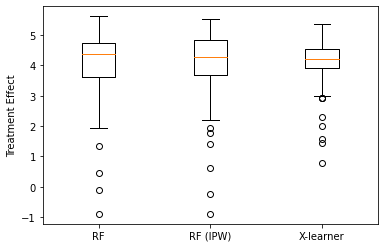

In [ ]:
plt.figure()
plt.boxplot([rf_te_out, rf_ipsw_te_out, xl_te_out.flatten()], labels=['RF', 'RF (IPW)', 'X-learner'])
plt.ylabel('Treatment Effect')

plt.show()

#### PEHE error

In [ ]:
rf_pehe_in = pehe_error(rf_te_in, te_train)
rf_pehe_out = pehe_error(rf_te_out, te_test)

rf_ipsw_pehe_in = pehe_error(rf_ipsw_te_in, te_train)
rf_ipsw_pehe_out = pehe_error(rf_ipsw_te_out, te_test)

xl_pehe_in = pehe_error(xl_te_in, te_train)
xl_pehe_out = pehe_error(xl_te_out, te_test)

In [ ]:
results = []
results.append(['RF', rf_pehe_in, rf_pehe_out])
results.append(['RF (IPW)', rf_ipsw_pehe_in, rf_ipsw_pehe_out])
results.append(['XL', xl_pehe_in, xl_pehe_out])

cols = ['Method', 'PEHE train', 'PEHE test']

df = pd.DataFrame(results, columns=cols)
df

,Method,PEHE train,PEHE test
0,RF,0.822712,0.607006
1,RF (IPW),0.841755,0.643509
2,XL,1.134552,1.282368


### 6. Model selection

In [ ]:
# Defines parameter search space for Random Forests.
params = {"max_leaf_nodes": [10, 20, 30, None], "max_depth": [5, 10, 20, None]}

#### Random Forest

In [ ]:
rf = GridSearchCV(RandomForestRegressor(), param_grid=params, n_jobs=-1, cv=5)

rf.fit(np.concatenate([x_train, t_train], axis=1), y_train.flatten())

rf_y0_in = rf.predict(np.concatenate([x_train, np.zeros_like(t_train)], axis=1))
rf_y1_in = rf.predict(np.concatenate([x_train, np.ones_like(t_train)], axis=1))

rf_y0_out = rf.predict(np.concatenate([x_test, np.zeros_like(t_test)], axis=1))
rf_y1_out = rf.predict(np.concatenate([x_test, np.ones_like(t_test)], axis=1))

rf_te_in = rf_y1_in - rf_y0_in
rf_te_out = rf_y1_out - rf_y0_out

#### Random Forest with IPW

In [ ]:
prop_clf = GridSearchCV(RandomForestClassifier(), param_grid=params, n_jobs=-1, cv=5)
weights = get_ps_weights(prop_clf, x_train, t_train)

rf_ipsw = GridSearchCV(RandomForestRegressor(), param_grid=params, n_jobs=-1, cv=5)
rf_ipsw.fit(np.concatenate([x_train, t_train], axis=1), y_train.flatten(), sample_weight=weights)

rf_ipsw_y0_in = rf_ipsw.predict(np.concatenate([x_train, np.zeros_like(t_train)], axis=1))
rf_ipsw_y1_in = rf_ipsw.predict(np.concatenate([x_train, np.ones_like(t_train)], axis=1))

rf_ipsw_y0_out = rf_ipsw.predict(np.concatenate([x_test, np.zeros_like(t_test)], axis=1))
rf_ipsw_y1_out = rf_ipsw.predict(np.concatenate([x_test, np.ones_like(t_test)], axis=1))

rf_ipsw_te_in = rf_ipsw_y1_in - rf_ipsw_y0_in
rf_ipsw_te_out = rf_ipsw_y1_out - rf_ipsw_y0_out

#### X-Learner

In [ ]:
reg = GridSearchCV(RandomForestRegressor(), param_grid=params, n_jobs=-1, cv=5)
clf = GridSearchCV(RandomForestClassifier(), param_grid=params, n_jobs=-1, cv=5)

xl = XLearner(models=reg, propensity_model=clf)
xl.fit(y_train, t_train.flatten(), X=x_train)

xl_te_in = xl.effect(x_train)
xl_te_out = xl.effect(x_test)

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


### 7. Evaluation
#### ATE error

In [ ]:
rf_ate_in = ate_error(rf_te_in, te_train)
rf_ate_out = ate_error(rf_te_out, te_test)

rf_ipsw_ate_in = ate_error(rf_ipsw_te_in, te_train)
rf_ipsw_ate_out = ate_error(rf_ipsw_te_out, te_test)

xl_ate_in = ate_error(xl_te_in, te_train)
xl_ate_out = ate_error(xl_te_out, te_test)

results = []
results.append(['RF', rf_ate_in, rf_ate_out])
results.append(['RF (IPW)', rf_ipsw_ate_in, rf_ipsw_ate_out])
results.append(['XL', xl_ate_in, xl_ate_out])

cols = ['Method', 'ATE train', 'ATE test']

df = pd.DataFrame(results, columns=cols)
df

,Method,ATE train,ATE test
0,RF,0.093059,0.052187
1,RF (IPW),0.043648,0.006808
2,XL,0.027406,0.024285


#### PEHE error

In [ ]:
rf_pehe_in = pehe_error(rf_te_in, te_train)
rf_pehe_out = pehe_error(rf_te_out, te_test)

rf_ipsw_pehe_in = pehe_error(rf_ipsw_te_in, te_train)
rf_ipsw_pehe_out = pehe_error(rf_ipsw_te_out, te_test)

xl_pehe_in = pehe_error(xl_te_in, te_train)
xl_pehe_out = pehe_error(xl_te_out, te_test)

In [ ]:
results = []
results.append(['RF', rf_pehe_in, rf_pehe_out])
results.append(['RF (IPW)', rf_ipsw_pehe_in, rf_ipsw_pehe_out])
results.append(['XL', xl_pehe_in, xl_pehe_out])

cols = ['Method', 'PEHE train', 'PEHE test']

df = pd.DataFrame(results, columns=cols)
df

,Method,PEHE train,PEHE test
0,RF,0.525752,0.528402
1,RF (IPW),0.544826,0.497027
2,XL,1.091623,1.223893
